# ResNet: Balanced Data Set 

After evaluating F1 Score, we want to train our model on balanced dataset and then predict the unbalanced dataset

### Initialize Notebook & packages

In [1]:
import helper as hp 
hp.initialize_notebook() # initialize with GPU enabled  
# hp.initialize_notebook(False) # to disable GPU 

2024-12-18 11:56:21.358453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 11:56:21.372954: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 11:56:21.377464: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 11:56:21.389395: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU enabled. Checking for available GPUs...
1 Physical GPUs, 1 Logical GPUs

Verifying TensorFlow and PyTorch CUDA setup...
TensorFlow version: 2.17.0
Built with CUDA: True
Num GPUs Available: 1

Keras version: 3.6.0

End checks and initialization.


I0000 00:00:1734522990.067277  591130 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734522990.136707  591130 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734522990.140675  591130 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734522990.145920  591130 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [2]:
# Import standard libraries
import os
import sys
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import keras
# Import DL libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout # General Layers
from keras.layers import RandomRotation, RandomFlip
from keras import layers, models, Model, Input
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from keras.metrics import F1Score, AUC
# Suppress tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import ML libraries
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

# Import image libraries
from skimage import transform
import tifffile as tiff
from tifffile import imread

# Appends current working dir
current_path = os.getcwd()
sys.path.append(current_path)

# Import custom preprocessing class
from imc_preprocessing import IMCPreprocessor

### Clear GPU memory

In [3]:
import tensorflow as tf
from keras import backend as K

# Clear TensorFlow session and reset the graph
K.clear_session()
tf.compat.v1.reset_default_graph()

## IMPORT DATA

### Train, validation and test split 

In [4]:
images_dir = '../../../IMC_images' 
metadata_dir = '../../../metadata.csv'
# --- Load CSV and filter dataset ---
csv_file = metadata_dir
image_folder = images_dir

# Load the CSV
df = pd.read_csv(csv_file)

# Filter rows with NA in PDL1_score and convert to binary
df = df.dropna(subset=["PDL1_score"])
df["PDL1_score"] = df["PDL1_score"].astype(int)

# --- Train-Test-Validation Split ---
train_df, val_and_test_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df["PDL1_score"])
test_df, val_df = train_test_split(val_and_test_df, test_size=0.5, random_state=42, stratify=val_and_test_df["PDL1_score"])


### Import function for dataset

In [25]:

# --- Load Images and Compute Mean and Standard Deviation ---
# Function to load a single image
def load_image(image_path):
    image = imread(image_path)  # Load all 46 channels
    return image.astype(np.float32)

# Initialize variables to accumulate sum and sum of squares
nr_images = 0
sum_images = np.zeros((46, 224, 224))
sum_squared_images = np.zeros((46, 224, 224))

# Accumulate the sum and sum of squares for the training dataset
for _, row in train_df.iterrows():
    image_path = os.path.join(image_folder, f"{row['sample_id']}.tiff")
    image = load_image(image_path)
    nr_images += 1
    sum_images += image
    sum_squared_images += image ** 2

# Compute mean and standard deviation
mean = sum_images / nr_images
std = np.sqrt(sum_squared_images / nr_images - mean ** 2)

# --- Dataset Loading Function ---

def load_dataset(dataframe, image_folder, normalize = True): # augment = False
    images = []
    labels = []
    
    for _, row in dataframe.iterrows():
        image_path = os.path.join(image_folder, f"{row['sample_id']}.tiff")
        image = load_image(image_path)

        if normalize:
            # image = np.arcsinh(image / 1) # arcsin transformation
            image = (image - mean) / std # Z-Score

        # Convert to channels-last format (224, 224, 46)
        image = np.transpose(image, (1, 2, 0))

        # # Apply data augmentation if specified
        # if augment:
        #     # Random horizontal flip
        #     if np.random.rand() > 0.5:
        #         image = np.flip(image, axis=2)
        #     # Random vertical flip
        #     if np.random.rand() > 0.5:
        #         image = np.flip(image, axis=1)

        images.append(image)
        labels.append(row["PDL1_score"])

    return np.array(images), np.array(labels)

## ResNet18: with Tensor Board + 3 Channels + with Dropout + ReduceLR + EarlyStopping + sigmoid instead of softmax + 1 neuron instead of 

Adjust the last classificaiton layer to contain 1 neuron and the sigmoid activation function (instead of 2 neurons and the softmax), because this is more suited for binary classificaiton. Model retrained underneath

### Create Datasets: Disable one-hot encoding for sigmoid / F1-Score

In [26]:
# Training dataset without augmentation
X_train, y_train = load_dataset(train_df, image_folder, normalize = True)
# # Training dataset with data augmentation
# X_train_aug, y_train_aug = load_dataset(train_df, image_folder, augment=True)
# Validation dataset
X_val, y_val = load_dataset(val_df, image_folder, normalize = True)
# Test dataset
X_test, y_test = load_dataset(test_df, image_folder, normalize = True)

# #  Disable for F1_score / Sigmoid 
# # One Hot Encoding
# y_train= to_categorical(y_train)
# y_val= to_categorical(y_val)
# y_test = to_categorical(y_test)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (590, 224, 224, 46), y_train shape: (590,)
X_val shape: (197, 224, 224, 46), y_val shape: (197,)
X_test shape: (197, 224, 224, 46), y_test shape: (197,)


### Drop biological irrelevant channels

In [27]:
def drop_channels(image, channels_of_interest, channel_names):
        channel_names_new = [i for i in channel_names if i not in channels_of_interest]
        mask = np.zeros(image.shape[2], dtype=bool) # Error: np.zeros(image.shape[0], dtype=bool) and NOT np.zeros(image.shape[2], dtype=bool) (ONLY ERROR IF YOU DONT TRANSPOSE THE IMAGE, OTHERWISE OKEY)
        
        for i in channels_of_interest:
            mask[channel_names.index(i)] = True
        image = image[:, :, mask] # Error: image[mask, :, :] and not image[:, :, mask] ! (ONLY ERROR IF YOU DONT TRANSPOSE THE IMAGE, OTHERWISE OKEY)
        
        return image

In [28]:
channel_names_new = ["Gd160", "Eu153", "Gd155"]

panel_dir = '../../../panel.csv' 
panel_df = pd.read_csv(panel_dir)
channel_names = dict(zip(panel_df['clean_target'].to_list(), panel_df['channel'].to_list()))

In [29]:
X_train = [drop_channels(i, channel_names_new, list(channel_names.values())) for i in X_train]
X_val = [drop_channels(i, channel_names_new, list(channel_names.values())) for i in X_val]
X_test = [drop_channels(i, channel_names_new, list(channel_names.values())) for i in X_test]

In [30]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)


### ResNet18: with Tensor Board + 3 Channels + with Dropout + ReduceLR + EarlyStopping + sigmoid (1 neuron) + binary cross entropy + 3 Channels

In [31]:
def identity_block(x, filter, dropout_rate = 0.5):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = Dropout(dropout_rate)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def convolutional_block(x, filter, dropout_rate = 0.5):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = Dropout(dropout_rate)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def ResNet(shape = (32, 32, 3), classes = 10, block_layers = [3, 4, 6, 3], dropout_rate = 0.5):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = block_layers
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x) # Change last layer here: sigmoid and 1 neuron (classes -1)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet18")
    return model

### Callbacks 

In [32]:
# Callbacks
log_dir = os.path.join("logs_ResNet50", "fit", "model_ResNet18_3_dropout_callbacks_sigmoid_biological_channels_trained" + time.strftime("%Y%m%d-%H%M%S"))
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=12,   # Optimal patience value for validation accuracy
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="./models_ResNet/model_ResNet18_3_dropout_callbacks_sigmoid_biological_channels_trained.keras", # save validation loss into file
        monitor="val_loss",  # monitor validation accuracy
        save_best_only=True,
    ),
    ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,  
    patience=3,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    min_lr=1.e-6,
    ), 
    tb_callback
]

### Train Model: NOW ONLY 3 CHANNELS

In [33]:
ROWS = 224; COLS = 224; CHANNELS = 3; CLASSES = 2; block_layers = [2,2,2,2] # ResNet18
dropout_rate = 0.5
# Build Network Graph 
model_ResNet18 = ResNet(shape = (ROWS, COLS, CHANNELS), classes = CLASSES, block_layers = block_layers, dropout_rate = dropout_rate)

# Compile Model 
l_rate = 1.e-4 # CHANGE HERE
opt = keras.optimizers.Adam(learning_rate=l_rate)
model_ResNet18.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"]) # Set threshold here

# Train Model 
batch = 64
epochs = 50
start_time = time.time()

history_ResNet18 = model_ResNet18.fit(X_train, y_train,
                                      epochs = epochs, batch_size = batch, 
                                      validation_data = (X_val, y_val), callbacks = callbacks_list)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nElapsed time: {elapsed_time} seconds")

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5609 - loss: 1.9094 - val_accuracy: 0.3959 - val_loss: 0.8857 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 512ms/step - accuracy: 0.7638 - loss: 0.7749 - val_accuracy: 0.7716 - val_loss: 0.5891 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 506ms/step - accuracy: 0.7882 - loss: 0.5208 - val_accuracy: 0.7411 - val_loss: 0.5466 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 517ms/step - accuracy: 0.7976 - loss: 0.4584 - val_accuracy: 0.7360 - val_loss: 0.5451 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 387ms/step - accuracy: 0.8503 - loss: 0.4005 - val_accuracy: 0.7208 - val_loss: 0.5528 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 369ms/step - accuracy: 0.8764 - loss: 0.3373 - val_accuracy: 0.7107 - val_loss: 0.5807 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0

### Testing Accuracy! 

In [34]:
# To load the model from file uncomment and run the following 
loaded_model = keras.saving.load_model('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_biological_channels_trained.keras')
print("Test Accuracy (for unbalanced test set) is: {:.2f}%".format(loaded_model.evaluate(X_test, y_test)[1]))

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.7775 - loss: 0.4833
Test Accuracy (for unbalanced test set) is: 0.77%


### F1-Score

In [22]:
from sklearn.metrics import f1_score

y_pred_test = loaded_model.predict(X_test)
y_pred_test = (y_pred_test > 0.5).astype(int)
f1 = f1_score(y_test, y_pred_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step


In [24]:
print("F1-Score (for balanced test set) is: {:.2f}".format(f1))

F1-Score (for balanced test set) is: 0.70


### Confusion Matrix

In [25]:
from sklearn.metrics import confusion_matrix
loaded_model = keras.saving.load_model('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_biological_channels_trained.keras')
y_pred_test = loaded_model.predict(X_test)
y_pred_test = (y_pred_test > 0.5).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step


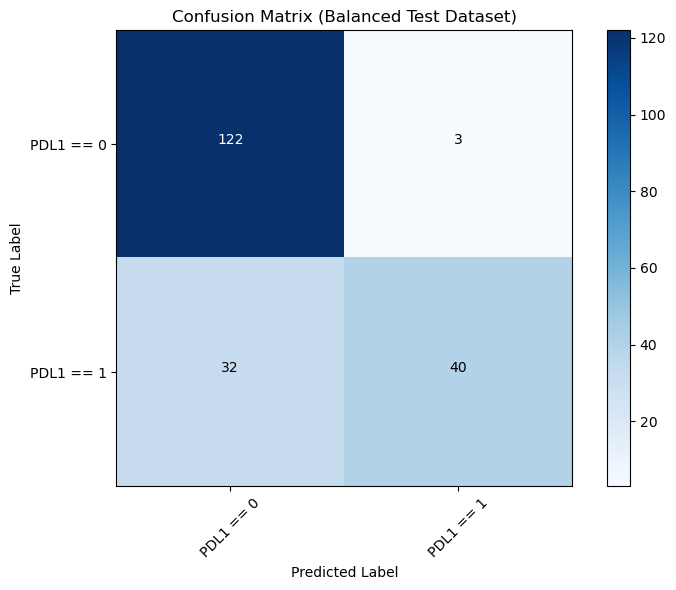

In [26]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (Balanced Test Dataset)")
    plt.colorbar()

    # Add class labels to axes
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add text annotations for each cell
    thresh = cm.max() / 2  # Threshold for text color
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


# # Example confusion matrix (computed earlier or loaded)
# cm_ex = np.array([
#     [50, 2, 1],
#     [5, 45, 3],
#     [2, 6, 40]
# ])

# Class names (optional, for labeling the axes)
class_names = ['PDL1 == 0', 'PDL1 == 1']

# Call the function to plot the confusion matrix
plot_confusion_matrix(cm, class_names)

### Saving History

In [31]:
# Save the history of your experiments 
import pickle
with open('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_biological_channels_trained.pkl', 'wb') as f:
    pickle.dump(history_ResNet18.history, f)

with open('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_biological_channels_trained.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

### Comments

When using only 3 channels, the model converges way faster than with all 46 channels!

    - Achieves similar accuracy, but lower F1 Score (Higher FN but lower FT)
    - Lets try with balanced dataset!

### ResNet18: with Tensor Board + 46 Channels + with Dropout + ReduceLR + EarlyStopping + sigmoid (1 neuron) + binary cross entropy + 3 Channels + BALANCED DATA

### Downsample majority class

In [7]:
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 41.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 59.7 MB/s eta 0:00:00:00:0100:01


In [9]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

# X_train: Define Undersampling balancing method
balancer = RandomUnderSampler(random_state = 42) # Undersampling majority class
X_train_flat = X_train.reshape(X_train.shape[0], -1) # Reshape images for balancer
X_train_resampled, y_train_resampled = balancer.fit_resample(X_train_flat, y_train) # resample (Undersampling)
X_train_resampled = X_train_resampled.reshape(-1, *X_train.shape[1:]) # Reshape the image

# X_val: Define Undersampling balancing method
balancer = RandomUnderSampler(random_state = 42) # Undersampling majority class
X_val_flat = X_val.reshape(X_val.shape[0], -1) # Reshape images for balancer
X_val_resampled, y_val_resampled = balancer.fit_resample(X_val_flat, y_val) # resample (Undersampling)
X_val_resampled = X_val_resampled.reshape(-1, *X_val.shape[1:]) # Reshape the image

ModuleNotFoundError: No module named 'imblearn'

### Callbacks

In [31]:
# Callbacks
log_dir = os.path.join("logs_ResNet50", "fit", "model_ResNet18_46_dropout_callbacks_sigmoid_balanced_biological_channels_trained" + time.strftime("%Y%m%d-%H%M%S"))
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=12,   # Optimal patience value for validation accuracy
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_balanced_biological_channels_trained.keras", # save validation loss into file
        monitor="val_loss",  # monitor validation accuracy
        save_best_only=True,
    ),
    ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,  
    patience=3,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    min_lr=1.e-6,
    ), 
    tb_callback
]

### Train Model on balanced training data set & only 3 channels

In [32]:
ROWS = 224; COLS = 224; CHANNELS = 3; CLASSES = 2; block_layers = [2,2,2,2] # ResNet18
dropout_rate = 0.5
# Build Network Graph 
model_ResNet18 = ResNet(shape = (ROWS, COLS, CHANNELS), classes = CLASSES, block_layers = block_layers, dropout_rate = dropout_rate)

# Compile Model 
l_rate = 1.e-4 # CHANGE HERE
opt = keras.optimizers.Adam(learning_rate=l_rate)
model_ResNet18.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"]) # Set threshold here

# Train Model 
batch = 64
epochs = 50
start_time = time.time()

history_ResNet18 = model_ResNet18.fit(X_train_resampled, y_train_resampled,
                                      epochs = epochs, batch_size = batch, 
                                      validation_data = (X_val_resampled, y_val_resampled), callbacks = callbacks_list)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nElapsed time: {elapsed_time} seconds")

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.6185 - loss: 0.9592 - val_accuracy: 0.5000 - val_loss: 0.8193 - learning_rate: 1.0000e-04
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 658ms/step - accuracy: 0.6853 - loss: 0.7468 - val_accuracy: 0.7042 - val_loss: 0.6207 - learning_rate: 1.0000e-04
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 599ms/step - accuracy: 0.6830 - loss: 0.6110 - val_accuracy: 0.7817 - val_loss: 0.5791 - learning_rate: 1.0000e-04
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 639ms/step - accuracy: 0.8066 - loss: 0.4800 - val_accuracy: 0.6831 - val_loss: 0.5784 - learning_rate: 1.0000e-04
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 646ms/step - accuracy: 0.8113 - loss: 0.4052 - val_accuracy: 0.6972 - val_loss: 0.5777 - learning_rate: 1.0000e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 652ms/step - accuracy: 0.8371 - loss: 0.3970 - val_accuracy: 0.7042 - val_loss: 0.5436 - learning_rate: 1.0000e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 706ms/step - accuracy: 0.8513 - loss: 0

### Testing Accuracy

In [33]:
# To load the model from file uncomment and run the following 
loaded_model = keras.saving.load_model('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_balanced_biological_channels_trained.keras')
print("Test Accuracy (for unbalanced test set) is: {:.2f}%".format(loaded_model.evaluate(X_test, y_test)[1]))

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.8213 - loss: 0.5212
Test Accuracy (for unbalanced test set) is: 0.82%


### Testing Accuracy on balanced test set

In [34]:
# X_train: Define Undersampling balancing method
import imblearn
from imblearn.under_sampling import RandomUnderSampler
balancer = RandomUnderSampler(random_state = 42) # Undersampling majority class
X_test_flat = X_test.reshape(X_test.shape[0], -1) # Reshape images for balancer
X_test_resampled, y_test_resampled = balancer.fit_resample(X_test_flat, y_test) # resample (Undersampling)
X_test_resampled = X_test_resampled.reshape(-1, *X_test.shape[1:]) # Reshape the image

/home/jupyter-luvogt/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jupyter-luvogt/.local/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/home/jupyter-luvogt/.local/lib/python3.12/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [35]:
print("Test Accuracy (for balanced test set) is: {:.2f}%".format(loaded_model.evaluate(X_test_resampled, y_test_resampled)[1]))

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 392ms/step - accuracy: 0.7953 - loss: 0.5485
Test Accuracy (for balanced test set) is: 0.78%


### F1-Score

In [36]:
from sklearn.metrics import f1_score

y_pred_test = loaded_model.predict(X_test_resampled)
y_pred_test = (y_pred_test > 0.5).astype(int)
f1 = f1_score(y_test_resampled, y_pred_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step


In [37]:
print("F1-Score (for balanced test set) is: {:.2f}".format(f1))

F1-Score (for balanced test set) is: 0.77


### Confusion Matrix

In [38]:
from sklearn.metrics import confusion_matrix
loaded_model = keras.saving.load_model('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_balanced_biological_channels_trained.keras')
y_pred_test = loaded_model.predict(X_test_resampled)
y_pred_test = (y_pred_test > 0.5).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test_resampled, y_pred_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step


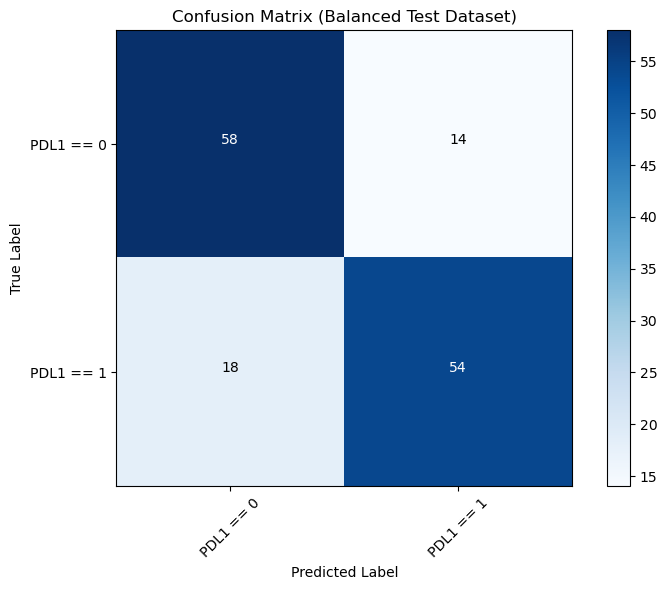

In [39]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (Balanced Test Dataset)")
    plt.colorbar()

    # Add class labels to axes
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add text annotations for each cell
    thresh = cm.max() / 2  # Threshold for text color
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


# # Example confusion matrix (computed earlier or loaded)
# cm_ex = np.array([
#     [50, 2, 1],
#     [5, 45, 3],
#     [2, 6, 40]
# ])

# Class names (optional, for labeling the axes)
class_names = ['PDL1 == 0', 'PDL1 == 1']

# Call the function to plot the confusion matrix
plot_confusion_matrix(cm, class_names)

### Saving Model History

In [40]:
# Save the history of your experiments 
import pickle
with open('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_balanced_biological_channels_trained.pkl', 'wb') as f:
    pickle.dump(history_ResNet18.history, f)

with open('./models_ResNet/model_ResNet18_46_dropout_callbacks_sigmoid_balanced_biological_channels_trained.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

### COMMENTS: 

With balanced dataset and biological relevant channels, we get: 

    - Test Accuracy (balanced dataset): 78%
    - F1 Score (balanced dataset): 0.77

Even though this is suprising, the validation accuracy was constantly smaller and the model seemed to have a hard time to overfit.